Этот ноутбук представляет собой практическое введение в основные методы системы рекомендаций (RecSys). Цель RecSys — рекомендовать релевантные элементы для пользователей на основе их предпочтений. Предпочтение и релевантность субъективны, и обычно они выводятся из продуктов, которые пользователи потребляли ранее.
Основные семейства методов RecSys:

* [Коллаборативная фильтрация](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BB%D0%BB%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F): этот метод автоматически прогнозирует (фильтрует) интересы пользователя, собирая информацию о предпочтениях или вкусах от многих пользователей (коллаборация). Основное предположение подхода совместной фильтрации состоит в том, что если человек А имеет то же мнение, что и человек Б по набору элементов, то А с большей вероятностью будет иметь мнение Б по данному элементу, чем мнение случайно выбранного человека.

* [Контентная фильтрация](https://habr.com/ru/company/piter/blog/350346/): Этот метод использует только информацию об описании и атрибутах элементов, которые пользователи ранее потребляли, для моделирования предпочтений пользователя. Другими словами, эти алгоритмы пытаются рекомендовать элементы, похожие на те, которые нравились пользователю в прошлом (или изучаются в настоящем). В частности, различные элементы-кандидаты сравниваются с элементами, предварительно оцененными пользователем, и рекомендуются наиболее подходящие элементы.

* [Гибридные методы](): Недавние исследования показали, что гибридный подход, сочетающий коллаборативную фильтрацию и фильтрацию на основе контента, в некоторых случаях может быть более эффективным, чем чистые подходы. Эти методы также можно использовать для преодоления некоторых общих проблем в рекомендательных системах, таких как холодный запуск и проблема разреженности.

В этом ноутбуке мы используем набор данных, который взяли на Kaggle: совместное использование и чтение статей из CI&T Deskdrop.
Мы продемонстрируем, как реализовать коллаборативную фильтрацию, контентную фильтрацию и гибридные методы в Python для предоставления персонализированных рекомендаций пользователям.

In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Загрузка данных: набор данных CI&T Deskdrop.

В этом разделе мы загружаем набор данных Deskdrop, который содержит реальную выборку журналов за 12 месяцев (март 2016 г. — февраль 2017 г.) с платформы внутренних коммуникаций CI&T (DeskDrop). Он содержит около 73 тысяч зарегистрированных взаимодействий пользователей с более чем 3 тысячами общедоступных статей, размещенных на платформе. Он состоит из двух файлов CSV:
* `shared_articles.csv`
* `users_interactions.csv`

Взгляните на эти ядра, чтобы получить лучшее представление о наборе данных:

* Наборы данных Deskdrop EDA
* DeskDrop Статьи Тема Моделирование

**shared_articles.csv**

Содержит информацию о статьях, опубликованных на платформе. У каждой статьи есть дата публикации (timestamp), исходный URL-адрес, заголовок, содержание в виде простого текста, язык статьи (португальский: pt или английский: en) и информация о пользователе, который поделился статьей (author).

Существует два возможных типа событий для данной временной метки:
* `CONTENT SHARED`: Статья была размещена на платформе и доступна для пользователей.
* `CONTENT REMOVED`: Статья была удалена с платформы и недоступна для дальнейших рекомендаций.

Для простоты мы рассматриваем здесь только тип события «CONTENT SHARED», предполагая (наивно), что все статьи были доступны в течение всего периода в один год. Для более точной оценки (и большей точности) следует рекомендовать только те статьи, которые были доступны в данное время.

In [2]:
articles_df = pd.read_csv('C:/Users/Александр/pj/pet_projects/Recommender Systems/Datasets/shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(5)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


**users_interactions.csv**

Содержит логи взаимодействия пользователей с общими статьями. Его можно присоединить к `article_shared.csv` по столбцу `contentId`.

Значения `eventType`:
* `VIEW`: Пользователь открыл статью.
* `LIKE`: Пользователю понравилась статья.
* `COMMENT CREATED`: Пользователь создал комментарий к статье.
* `FOLLOW`: пользователь решил получать уведомления о любых новых комментариях к статье.
* `BOOKMARK`: пользователь добавил статью в закладки, чтобы ее можно было легко вернуться в будущем.

In [3]:
interactions_df = pd.read_csv('C:/Users/Александр/pj/pet_projects/Recommender Systems/Datasets/users_interactions.csv')
interactions_df.head(10)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,NaN,NaN,NaN
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN


## Data Munging

Поскольку существуют разные типы взаимодействий, мы связываем их с весом или силой, предполагая, что, например, комментарий в статье свидетельствует о более высоком интересе пользователя к элементу, чем лайк или простой просмотр.

In [4]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength[x])

У рекомендательных систем есть проблема, известная как [«холодный старт»](https://habr.com/ru/company/surfingbird/blog/168733/) пользователя, при которой трудно предоставить персонализированные рекомендации для пользователей, которые не потребляют совсем или потребляют очень мало товаров, из-за отсутствия информации для моделирования их предпочтений.
По этой причине мы сохраняем в наборе данных только пользователей с не менее чем 5 взаимодействиями.

In [5]:
users_interactions_count_df = interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

# users: 1895
# users with at least 5 interactions: 1140


In [6]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 72312
# of interactions from users with at least 5 interactions: 69868


В Deskdrop пользователям разрешено просматривать статью много раз и взаимодействовать с ней различными способами (например, ставить лайки или оставлять комментарии). Таким образом, чтобы смоделировать интерес пользователя к данной статье, мы объединяем все взаимодействия, которые пользователь выполнил с элементом, по взвешенной сумме силы типа взаимодействия и применяем логарифмическое преобразование для сглаживания распределения.

In [7]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                       .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                       .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# of unique user/item interactions: 39106


,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925
5,-9223121837663643404,-7331393944609614247,1.000000
6,-9223121837663643404,-6872546942144599345,1.000000
7,-9223121837663643404,-6728844082024523434,1.000000
8,-9223121837663643404,-6590819806697898649,1.000000
9,-9223121837663643404,-6558712014192834002,1.584963


## Оценка

Оценка важна для проектов машинного обучения, потому что она позволяет объективно сравнивать различные алгоритмы и выбор гиперпараметров для моделей. Одним из ключевых аспектов оценки является обеспечение того, чтобы обученная модель обобщала данные, на которых она не обучалась, с использованием методов перекрестной проверки (cross-validation). Мы используем здесь простой подход перекрестной проверки, называемый удержанием, при котором случайная выборка данных (в данном случае 20%) откладывается в процессе обучения и используется исключительно для оценки. Все представленные здесь показатели оценки вычисляются с использованием тестового набора.

P.S. Более надежный подход к оценке может заключаться в разделении обучающих и тестовых наборов по контрольной дате, где обучающий набор состоит из всех взаимодействий до этой даты, а тестовый набор представляет собой взаимодействия после этой даты. Ради простоты мы выбрали первый случайный подход для этого ноутбука, но вы можете попробовать второй подход, чтобы лучше смоделировать, как recsys будет работать в производственной среде, предсказывая «будущие» взаимодействия пользователей.

In [8]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 31284
# interactions on Test set: 7822


В рекомендательных системах существует набор показателей, обычно используемых для оценки. Мы решили работать с метриками точности Top-N, которые оценивают точность лучших рекомендаций, предоставленных пользователю, по сравнению с элементами, с которыми пользователь фактически взаимодействовал в тестовом наборе.
Этот метод оценки работает следующим образом:
* Для каждого пользователя
  + Для каждого элемента, с которым взаимодействовал пользователь в тестовом наборе
    + Выборка из 100 других элементов, с которыми пользователь никогда не взаимодействовал.
      P.S. Здесь мы наивно предполагаем, что эти не взаимодействующие элементы не имеют отношения к пользователю, что может быть       неправдой, поскольку пользователь может просто не знать об этих не взаимодействующих элементах. Но оставим это   предположение.
    + Попросим рекомендательную модель создать ранжированный список рекомендуемых элементов из набора, состоящего из одного   элемента, с которым взаимодействовали, и 100 элементов, с которыми не взаимодействовали («нерелевантные!»)
    + Вычислим Top-N показателей точности для этого пользователя и элемента, с которым он взаимодействовал, из ранжированного списка рекомендаций.
* Агрегируем глобальные показатели точности Top-N

-----

Выбранная метрика точности Top-N это Recall@N, которая оценивает, входит ли взаимодействующий элемент в число первых N элементов (попаданий) в ранжированном списке из 101 рекомендации для пользователя.
P.S. Другими популярными показателями ранжирования являются NDCG@N и MAP@N, при расчете баллов которых учитывается положение соответствующего элемента в ранжированном списке (максимальное значение, если соответствующий элемент находится на первом месте). Вы можете найти ссылку на реализацию этой метрики в этом посте.

In [9]:
#Индексация по personId для ускорения поиска во время оценки
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [10]:
def get_items_interacted(person_id, interactions_df):
    # Получаем данные пользователя и объединяем с информацией о фильме.
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [11]:
#Константа показателей точности Top-N
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Получение элементов в тестовом наборе
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Получение ранжированного списка рекомендаций из модели для данного пользователя
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #Для каждого элемента, с которым взаимодействовал пользователь в тестовом наборе
        for item_id in person_interacted_items_testset:
            #Получение случайной выборки (100) элементов, с которыми пользователь не взаимодействовал 
            #(для представления элементов, которые, как предполагается, не имеют отношения к пользователю)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Объединение текущего объекта, с которым взаимодействовали, со 100 случайными объектами
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Фильтрация только рекомендаций, которые являются либо элементом, с которым взаимодействовали, 
            #либо случайной выборкой из 100 элементов, с которыми не взаимодействовали.
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            #Проверка того, входит ли текущий элемент, с которым взаимодействовали, в число рекомендуемых элементов Top-N
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall – это количество взаимодействующих элементов, которые входят в топ-N рекомендованных элементов
        #при смешивании с набором нерелевантных предметов
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()    

## Popularity model

Распространенным (и обычно трудно превзойденным) базовым подходом является Popularity model. Эта модель на самом деле не является персонализированной — она просто рекомендует пользователю самые популярные товары, которые пользователь ранее не потреблял. Поскольку популярность объясняет «мудрость толпы», она обычно дает хорошие рекомендации, как правило, интересные для большинства людей.

P.S. Основная цель рекомендательной системы — использовать элементы с длинным хвостом для пользователей с очень конкретными интересами, что выходит далеко за рамки этой простой техники.

In [12]:
#Вычисляем самые популярные предметы
item_popularity_df = interactions_full_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,contentId,eventStrength
0,-4029704725707465084,307.733799
1,-6783772548752091658,233.762157
2,-133139342397538859,228.024567
3,-8208801367848627943,197.107608
4,-6843047699859121724,193.825208
5,8224860111193157980,189.044680
6,-2358756719610361882,183.110951
7,2581138407738454418,180.282876
8,7507067965574797372,179.094002
9,1469580151036142903,170.548969


In [13]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Рекомендовать более популярные товары, которые пользователь еще не видел.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventStrength', 'contentId', \
                                                                                   'title', 'url', 'lang']]


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, articles_df)

Здесь мы выполняем оценку Popularity model в соответствии с методом, описанным выше.
Он достиг Recall@5, равного 0,2417, что означает, что около 24% элементов, с которыми взаимодействовали в тестовом наборе, были ранжированы по модели популярности среди первых 5 элементов (из списков со 100 случайными элементами). А Recall@10 оказался еще выше (37%), как и ожидалось.
Вас может удивить, что обычные Popularity model могут работать так хорошо!

In [14]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
1139 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.2418818716440808, 'recall@10': 0.3725389925850166}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,28,50,192,0.145833,0.260417,3609194402293569455
17,12,25,134,0.089552,0.186567,-2626634673110551643
16,13,23,130,0.100000,0.176923,-1032019229384696495
10,5,9,117,0.042735,0.076923,-1443636648652872475
82,26,40,88,0.295455,0.454545,-2979881261169775358
161,12,18,80,0.150000,0.225000,-3596626804281480007
65,20,34,73,0.273973,0.465753,1116121227607581999
81,17,23,69,0.246377,0.333333,692689608292948411
106,14,18,69,0.202899,0.260870,-9016528795238256703
52,21,28,68,0.308824,0.411765,3636910968448833585


## Контентная модель фильтрации

Подходы к контентной фильтрации используют описание или атрибуты элементов, с которыми взаимодействовал пользователь, чтобы рекомендовать похожие элементы. Это зависит только от предыдущего выбора пользователя, что делает этот метод надежным, чтобы избежать проблемы с холодным запуском. Для текстовых элементов, таких как статьи, новости и книги, просто использовать необработанный текст для создания профилей элементов и профилей пользователей.

Здесь мы используем очень популярную технику поиска информации (search engines) под названием [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). Этот метод преобразует неструктурированный текст в векторную структуру, где каждое слово представлено позицией в векторе, а значение измеряет, насколько релевантно данное слово для статьи. поскольку все элементы будут представлены в одной и той же [модели векторного пространства](https://en.wikipedia.org/wiki/Vector_space_model), это необходимо для вычисления сходства между статьями. 

См. [эту](https://www.slideshare.net/gabrielspmoreira/discovering-users-topics-of-interest-in-recommender-systems-tdc-sp-2016) презентацию (со слайда 30) для получения дополнительной информации о сходстве TF-IDF и косинуса.

In [15]:
#Игнорирование стоп-слов (слов без семантики) из английского и португальского языков 
#(поскольку у нас есть корпус со смешанными языками).
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

#Обучает модель, размер векторов которой составляет 5000, состоящую из основных униграмм и биграмм,
#найденных в корпусе, игнорируя стоп-слова.
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = articles_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(articles_df['title'] + "" + articles_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<3047x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 638118 stored elements in Compressed Sparse Row format>

Чтобы смоделировать профиль пользователя, мы берем все профили элементов, с которыми взаимодействовал пользователь, и усредняем их. Среднее значение взвешивается силой взаимодействия, другими словами, статьи, с которыми пользователь взаимодействовал чаще всего (например, понравившиеся или прокомментированные), будут иметь более высокую силу в конечном профиле пользователя.

In [46]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Средневзвешенное значение профилей предметов по силе взаимодействия
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / \
    np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_train_df[interactions_train_df['contentId'] \
                                                   .isin(articles_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [17]:
user_profiles = build_users_profiles()
len(user_profiles)

1140

Посмотрим в профили. Это единичный вектор длиной 5000. Значение в каждой позиции показывает, насколько актуален для меня токен (униграмма или биграмма).
Глядя на мой профиль, кажется, что наиболее релевантные токены действительно представляют мои профессиональные интересы в области машинного обучения, глубокого обучения, искусственного интеллекта и облачной платформы Google! Так что мы можем ожидать хороших рекомендаций здесь!

In [18]:
myprofile = user_profiles[-1479311724257856983]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[-1479311724257856983].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 5000)


,token,relevance
0,learning,0.298835
1,machine learning,0.246087
2,machine,0.237933
3,google,0.203117
4,data,0.169849
5,ai,0.156280
6,algorithms,0.115706
7,like,0.097790
8,language,0.087673
9,people,0.082061


In [19]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Вычисляет косинусное сходство между профилем пользователя и профилями всех элементов.
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Получает топ похожих товаров
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Сортирует похожие товары по сходству
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Игнорирует элементы, с которыми пользователь уже взаимодействовал
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', \
                                                                                   'title', 'url', 'lang']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(articles_df)

С персонализированными рекомендациями модели контентной фильтрации у нас есть Recall@5 примерно до `0.162`, это означает, что около `16%` элементов, с которыми взаимодействовали в тестовом наборе, были ранжированы этой моделью среди первых 5 элементов (из списков со 100 случайными элементами). ). А Recall@10 был `0.261` (`52%`). Более низкая производительность модели на основе контента по сравнению с моделью популярности может указывать на то, что пользователи не настолько привязаны к контенту, который очень похож на их предыдущие чтения.

In [20]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
1139 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.16338532344668882, 'recall@10': 0.26118639734083354}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,15,24,192,0.078125,0.125000,3609194402293569455
17,18,29,134,0.134328,0.216418,-2626634673110551643
16,20,33,130,0.153846,0.253846,-1032019229384696495
10,32,46,117,0.273504,0.393162,-1443636648652872475
82,6,15,88,0.068182,0.170455,-2979881261169775358
161,11,23,80,0.137500,0.287500,-3596626804281480007
65,8,13,73,0.109589,0.178082,1116121227607581999
81,8,19,69,0.115942,0.275362,692689608292948411
106,3,9,69,0.043478,0.130435,-9016528795238256703
52,3,8,68,0.044118,0.117647,3636910968448833585


## Коллаборативная фильтрация

Коллаборативная фильтрация (CF) имеет две основные стратегии реализации:
* `Memory-based`: Этот подход использует память о предыдущих взаимодействиях пользователей для вычисления сходства пользователей на основе элементов, с которыми они взаимодействовали (подход user-based), или вычисления сходства элементов на основе пользователей, которые с ними взаимодействовали (подход item-based). Типичным примером такого подхода является CF на основе пользовательского окружения, в котором для пользователя выбираются первые N похожих пользователей (обычно вычисляемых с использованием корреляции Пирсона), которые используются для рекомендации элементов, которые понравились похожим пользователям, но текущий пользователь не взаимодействовал с ними. Пока что. Этот подход очень прост в реализации, но обычно плохо масштабируется для многих пользователей. Хорошая реализация этого подхода на Python доступна в [Crab](http://muricoca.github.io/crab/).
* `Model-based`: При таком подходе модели разрабатываются с использованием различных алгоритмов машинного обучения, чтобы рекомендовать элементы пользователям. Существует множество алгоритмов CF на основе моделей, таких как нейронные сети, байесовские сети, модели кластеризации и модели скрытых факторов, такие как Сингулярное разложение (Singular Value Decomposition, SVD) и вероятностный латентно-семантический анализ.

### Матричная факторизация
Модели скрытых факторов сжимают матрицу пользовательских элементов в низкоразмерное представление с точки зрения скрытых факторов. Одним из преимуществ использования этого подхода является то, что вместо матрицы высокой размерности, содержащей большое количество пропущенных значений, мы будем иметь дело с матрицей гораздо меньшего размера в пространстве меньшей размерности.

Сокращенное представление можно использовать для алгоритмов соседства на основе user-based или item-based, которые представлены в предыдущем разделе. У этой парадигмы есть несколько преимуществ. Он обрабатывает разреженность исходной матрицы лучше, чем основанные на памяти. Кроме того, сравнение сходства по результирующей матрице гораздо более масштабируемо, особенно при работе с большими разреженными наборами данных.

Здесь мы используем популярную модель скрытого фактора под названием [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition). Существуют и другие фреймворки матричной факторизации, более специфичные для CF, которые вы можете попробовать, например, [surprise](https://github.com/NicolasHug/Surprise), [mrec](https://github.com/Mendeley/mrec) или [python-recsys](https://github.com/ocelma/python-recsys). Мы выбрали реализацию SVD в SciPy, потому что она доступна в ядрах Kaggle. P.S. См. пример SVD в наборе данных фильмов в этом [посте](https://beckernick.github.io/matrix-factorization-recommender/).

Важным решением является количество факторов для факторизации матрицы user-item. Чем больше число факторов, тем точнее факторизация исходных матричных реконструкций. Следовательно, если модели позволить запомнить слишком много деталей исходной матрицы, она может плохо обобщать данные, на которых она не обучалась. Уменьшение числа факторов увеличивает обобщение модели.

In [21]:
#Создание разреженной сводной таблицы с пользователями в строках и элементами в столбцах
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9172673334835262304,-9171475473795142532,-9166778629773133902,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9188188261933657343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9172914609055320039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9156344805277471150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9120685872592674274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
users_items_pivot_matrix = users_items_pivot_matrix_df.to_numpy()
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[-9223121837663643404,
 -9212075797126931087,
 -9207251133131336884,
 -9199575329909162940,
 -9196668942822132778,
 -9188188261933657343,
 -9172914609055320039,
 -9156344805277471150,
 -9120685872592674274,
 -9109785559521267180]

In [26]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<1140x2926 sparse matrix of type '<class 'numpy.float64'>'
	with 31284 stored elements in Compressed Sparse Row format>

In [27]:
#Количество факторов для факторизации матрицы элементов пользователя.
NUMBER_OF_FACTORS_MF = 15
#Выполняет матричную факторизацию исходной матрицы пользовательского элемента.
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [28]:
U.shape

(1140, 15)

In [29]:
Vt.shape

(15, 2926)

In [30]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

После факторизации мы пытаемся восстановить исходную матрицу, перемножив ее факторы. Полученная матрица уже не является разреженной. Были сгенерированы прогнозы для элементов, с которыми пользователь еще не взаимодействовал, которые мы будем использовать для рекомендаций.

In [31]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 0.01039915,  0.00081872, -0.01725263, ...,  0.00140708,
         0.0110647 ,  0.00226063],
       [-0.00019285, -0.00031318, -0.00264624, ...,  0.00251658,
         0.00017609, -0.00189488],
       [-0.01254721,  0.0065947 , -0.00590676, ...,  0.00698975,
        -0.01015696,  0.01154572],
       ...,
       [-0.02995379,  0.00805715, -0.01846307, ..., -0.01083078,
        -0.00118591,  0.0096798 ],
       [-0.01845505,  0.00467019,  0.01219602, ...,  0.00409507,
         0.00019482, -0.00752562],
       [-0.01506374,  0.00327732,  0.13391269, ..., -0.01191815,
         0.06422074,  0.01303244]])

In [33]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / \
(all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [34]:
#Преобразование реконструированной матрицы обратно в датафрейм Pandas
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids) \
                .transpose()
cf_preds_df.head(10)

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.139129,0.137930,0.136531,0.143948,0.136815,0.137339,0.137508,0.143534,0.136428,0.135681,...,0.137351,0.127822,0.137946,0.139653,0.140324,0.136888,0.135787,0.134560,0.135862,0.136246
-9216926795620865886,0.138044,0.137916,0.138698,0.137878,0.137969,0.137990,0.137974,0.138049,0.138217,0.138151,...,0.137962,0.139527,0.138009,0.138117,0.139634,0.138058,0.138222,0.138864,0.138480,0.138323
-9194572880052200111,0.135998,0.137652,0.137283,0.137536,0.140363,0.137807,0.141246,0.136284,0.135301,0.138512,...,0.139257,0.143161,0.139139,0.140077,0.154976,0.140109,0.140654,0.135861,0.139332,0.153114
-9192549002213406534,0.141924,0.137996,0.134663,0.137080,0.139946,0.138574,0.139473,0.144469,0.143333,0.138428,...,0.140233,0.167426,0.138849,0.137037,0.141820,0.139260,0.139513,0.136804,0.140862,0.148793
-9190737901804729417,0.140209,0.137408,0.138708,0.138672,0.137725,0.138218,0.138390,0.138418,0.134883,0.140193,...,0.138373,0.138459,0.138169,0.137990,0.134041,0.137820,0.138100,0.138286,0.138630,0.136178
-9189659052158407108,0.138932,0.138699,0.138117,0.137621,0.138920,0.137766,0.138568,0.138200,0.140572,0.140365,...,0.140725,0.148152,0.137645,0.138165,0.149152,0.138912,0.139595,0.139807,0.140419,0.145698
-9176143510534135851,0.143208,0.138673,0.139514,0.139114,0.137664,0.137447,0.139833,0.140564,0.144698,0.144440,...,0.138367,0.146220,0.136204,0.138087,0.137317,0.137917,0.138546,0.142601,0.141431,0.142154
-9172673334835262304,0.138527,0.138021,0.138274,0.137827,0.137997,0.138037,0.138104,0.138259,0.137633,0.138397,...,0.138588,0.140146,0.138013,0.137839,0.137033,0.137969,0.138337,0.138361,0.138813,0.137538
-9171475473795142532,0.140720,0.137865,0.138061,0.137633,0.138231,0.138089,0.139009,0.137552,0.137143,0.140581,...,0.139046,0.139895,0.138000,0.137958,0.136061,0.138183,0.138817,0.138060,0.139205,0.137198


In [35]:
len(cf_preds_df.columns)

1140

In [36]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Получает и сортирует прогнозы пользователя
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        #Рекомендует фильмы с наивысшим прогнозируемым рейтингом, которые пользователь еще не видел.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 
                                                                                   'title', 'url', 'lang']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, articles_df)

Оценивая модель Collaborative Filtering (факторизация матрицы SVD), мы видим, что мы получили значения `Recall@5` (`33%`) и `Recall@10` (`46%`), намного выше, чем модели Popularity и Content-Based.

In [37]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
1139 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.33392994119151115, 'recall@10': 0.46803886474047557}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,21,46,192,0.109375,0.239583,3609194402293569455
17,30,56,134,0.223881,0.417910,-2626634673110551643
16,16,34,130,0.123077,0.261538,-1032019229384696495
10,38,51,117,0.324786,0.435897,-1443636648652872475
82,39,48,88,0.443182,0.545455,-2979881261169775358
161,22,34,80,0.275000,0.425000,-3596626804281480007
65,24,32,73,0.328767,0.438356,1116121227607581999
81,16,21,69,0.231884,0.304348,692689608292948411
106,20,28,69,0.289855,0.405797,-9016528795238256703
52,23,30,68,0.338235,0.441176,3636910968448833585


## Гибридные методы

Что, если мы объединим подходы Collaborative Filtering и Content-Based Filtering?

Даст ли это нам более точные рекомендации?

Фактически, во многих исследованиях гибридные методы показали лучшие результаты, чем индивидуальные подходы, и широко используются исследователями и практиками.

Давайте создадим простой метод гибридизации в виде ансамбля, который берет средневзвешенное значение нормализованных оценок CF с оценками, основанными на содержании, и ранжирует по полученной оценке. В этом случае, поскольку модель CF намного точнее модели CB, веса для моделей CF и CB равны 100.0 и 1.0 соответственно.

In [38]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.cb_ensemble_weight = cb_ensemble_weight
        self.cf_ensemble_weight = cf_ensemble_weight
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Получение 1000 лучших рекомендаций по content-based фильтрации
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Получение 1000 лучших рекомендаций по collaborative фильтрации
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Объединение результатов по contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'outer', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId').fillna(0.0)
        
        #Вычисление гибридной оценки рекомендации на основе оценок CF и CB
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF'] 
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCB'] * self.cb_ensemble_weight) \
                                     + (recs_df['recStrengthCF'] * self.cf_ensemble_weight)
        
        #сортировка рекомендаций по гибридной оценке
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId', \
                                                                                   'title', 'url', 'lang']]


        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, articles_df,
                                             cb_ensemble_weight=1.0, cf_ensemble_weight=100.0)

У нас новый чемпион!

Наш простой гибридный подход превосходит контентную фильтрацию благодаря сочетанию с коллаборативной фильтрацией. Теперь у нас есть `Recall@5`, равный `34,2%`, и `Recall@10`, равный `47,9%`.

In [39]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
1139 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.3430069036052161, 'recall@10': 0.479033495269752}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,22,45,192,0.114583,0.234375,3609194402293569455
17,31,58,134,0.231343,0.432836,-2626634673110551643
16,21,37,130,0.161538,0.284615,-1032019229384696495
10,40,51,117,0.341880,0.435897,-1443636648652872475
82,38,50,88,0.431818,0.568182,-2979881261169775358
161,23,35,80,0.287500,0.437500,-3596626804281480007
65,23,32,73,0.315068,0.438356,1116121227607581999
81,16,21,69,0.231884,0.304348,692689608292948411
106,20,27,69,0.289855,0.391304,-9016528795238256703
52,22,29,68,0.323529,0.426471,3636910968448833585


## Сравнение методов

In [40]:
global_metrics_df = pd.DataFrame([cb_global_metrics, pop_global_metrics, cf_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@5,recall@10
modelName,,
Content-Based,0.163385,0.261186
Popularity,0.241882,0.372539
Collaborative Filtering,0.333930,0.468039
Hybrid,0.343007,0.479033


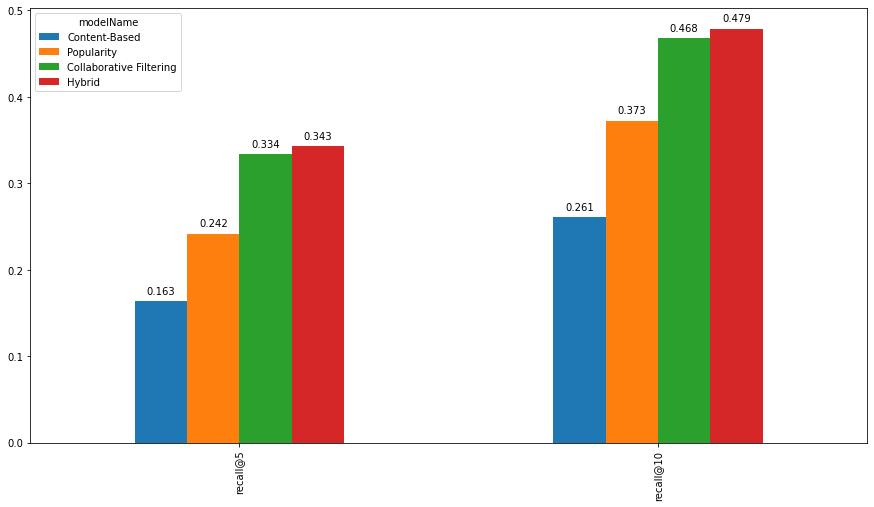

In [41]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', \
                va='center', xytext=(0, 10), textcoords='offset points')

## Тестирование

Давайте протестируем лучшую модель (гибрид) для моего профиля.

In [42]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id].merge(articles_df, how = 'left', 
                                                      left_on = 'contentId', 
                                                      right_on = 'contentId') \
                          .sort_values('eventStrength', ascending = False)[['eventStrength', 
                                                                          'contentId',
                                                                          'title', 'url', 'lang']]

Здесь мы видим некоторые статьи, с которыми я взаимодействовал в Deskdrop из тренировочного набора. Легко заметить, что среди моих основных интересов машинное обучение, глубокое обучение, искусственный интеллект и облачная платформа Google.

In [43]:
inspect_interactions(-1479311724257856983, test_set=False).head(20)

,eventStrength,contentId,title,url,lang
115,4.285402,7342707578347442862,"At eBay, Machine Learning is Driving Innovativ...",https://www.ebayinc.com/stories/news/at-ebay-m...,en
38,4.129283,621816023396605502,AI Is Here to Help You Write Emails People Wil...,http://www.wired.com/2016/08/boomerang-using-a...,en
8,4.044394,-4460374799273064357,"Deep Learning for Chatbots, Part 1 - Introduction",http://www.wildml.com/2016/04/deep-learning-fo...,en
116,3.954196,-7959318068735027467,Auto-scaling scikit-learn with Spark,https://databricks.com/blog/2016/02/08/auto-sc...,en
10,3.906891,2589533162305407436,6 reasons why I like KeystoneML,http://radar.oreilly.com/2015/07/6-reasons-why...,en
28,3.700440,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
6,3.700440,-398780385766545248,10 Stats About Artificial Intelligence That Wi...,http://www.fool.com/investing/2016/06/19/10-st...,en
113,3.643856,-6467708104873171151,5 reasons your employees aren't sharing their ...,http://justcuriousblog.com/2016/04/5-reasons-y...,en
42,3.523562,-4944551138301474550,Algorithms and architecture for job recommenda...,https://www.oreilly.com/ideas/algorithms-and-a...,en
43,3.459432,-8377626164558006982,Bad Writing Is Destroying Your Company's Produ...,https://hbr.org/2016/09/bad-writing-is-destroy...,en


Рекомендации действительно соответствуют моим интересам, так как я бы прочитал их все!

In [44]:
hybrid_recommender_model.recommend_items(-1479311724257856983, topn=20, verbose=True)

,recStrengthHybrid,contentId,title,url,lang
0,25.437103,3269302169678465882,The barbell effect of machine learning.,http://techcrunch.com/2016/06/02/the-barbell-e...,en
1,25.369932,-8085935119790093311,Graph Capabilities with the Elastic Stack,https://www.elastic.co/webinars/sneak-peek-of-...,en
2,24.493428,1005751836898964351,Seria Stranger Things uma obra de arte do algo...,https://www.linkedin.com/pulse/seria-stranger-...,pt
3,24.383245,-8377626164558006982,Bad Writing Is Destroying Your Company's Produ...,https://hbr.org/2016/09/bad-writing-is-destroy...,en
4,24.362064,-6727357771678896471,This Super Accurate Portrait Selection Tech Us...,http://petapixel.com/2016/06/29/super-accurate...,en
5,24.190477,-8190931845319543363,Machine Learning Is At The Very Peak Of Its Hy...,https://arc.applause.com/2016/08/17/gartner-hy...,en
6,24.172447,7395435905985567130,The AI business landscape,https://www.oreilly.com/ideas/the-ai-business-...,en
7,23.932057,5092635400707338872,Power to the People: How One Unknown Group of ...,https://medium.com/@atduskgreg/power-to-the-pe...,en
8,23.865831,-5253644367331262405,"Hello, TensorFlow!",https://www.oreilly.com/learning/hello-tensorflow,en
9,23.811686,1549650080907932816,Spark comparison: AWS vs. GCP,https://www.oreilly.com/ideas/spark-comparison...,en


## Вывод

В этом ноутбуке мы изучили и сравнили основные методы Recommender Systems в наборе данных CI&T Deskdrop. Можно заметить, что для рекомендаций по статьям фильтрация на основе контента и гибридный метод работают лучше, чем только коллаборативная фильтрация.

Есть большие возможности для улучшения результатов. Вот несколько советов:
* В этом примере мы полностью проигнорировали время, учитывая, что все статьи были доступны для рекомендации пользователям в любое время. Лучшим подходом было бы фильтровать только те статьи, которые были доступны для пользователей в данный момент времени.
* Вы можете использовать доступную контекстную информацию для моделирования предпочтений пользователей во времени (период дня, день недели, месяц), местоположении (страна и штат/район) и устройствах (браузер, родное мобильное приложение). Эта контекстуальная информация может быть легко включена в модели [Learn-to-Rank](https://en.wikipedia.org/wiki/Learning_to_rank) (такие как XGBoost Gradient Boosting Decision Trees с целью ранжирования), логистические модели (с категориальными функциями, [One-Hot encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) или [Feature Hashed](https://en.wikipedia.org/wiki/Feature_hashing)), а также модели [Wide & Deep](https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html), которые реализованы в [TensorFlow](https://docs.w3cub.com/tensorflow~guide/tutorials/wide_and_deep/).
* Эти основные приемы использовались в дидактических целях. В исследовательском сообществе RecSys есть более продвинутые методы, специальные продвинутые модели Matrix Factorization и Deep Learning.

Вы можете узнать больше о современных методах, опубликованных в Recommender Systems на конференции [ACM RecSys](https://recsys.acm.org/).
Если вы больше похожи на практика, чем на исследователя, вы можете попробовать некоторые фреймворки совместной фильтрации в этом наборе данных, такие как [surprise](https://github.com/NicolasHug/Surprise), [mrec](https://github.com/Mendeley/mrec), [python-recsys](https://github.com/ocelma/python-recsys) и [Spark ALS Matrix Factorization](https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html) (распределенная реализация для больших наборов данных).
Взгляните на [эту презентацию](https://www.slideshare.net/gabrielspmoreira/discovering-users-topics-of-interest-in-recommender-systems-tdc-sp-2016), где описывается производственная рекомендательная система, ориентированная на методы фильтрации на основе контента и тематического моделирования.